Epoch 1/200
60000/60000 [==============================] - 7s 111us/step - loss: -9233.6348
Epoch 2/200
60000/60000 [==============================] - 5s 90us/step - loss: -9506.6750
Epoch 3/200
60000/60000 [==============================] - 6s 98us/step - loss: -9546.3567
Epoch 4/200
60000/60000 [==============================] - 5s 91us/step - loss: -9580.3422
Epoch 5/200
60000/60000 [==============================] - 5s 92us/step - loss: -9606.0784
Epoch 6/200
60000/60000 [==============================] - 6s 96us/step - loss: -9622.7360
Epoch 7/200
60000/60000 [==============================] - 5s 91us/step - loss: -9633.8897
Epoch 8/200
60000/60000 [==============================] - 5s 91us/step - loss: -9643.0008
Epoch 9/200
60000/60000 [==============================] - 6s 99us/step - loss: -9650.8759
Epoch 10/200
60000/60000 [==============================] - 5s 83us/step - loss: -9656.8071
Epoch 11/200
60000/60000 [==============================] - 5s 80us/step - loss: -9661.8

60000/60000 [==============================] - 6s 93us/step - loss: -9739.1807
Epoch 91/200
60000/60000 [==============================] - 6s 98us/step - loss: -9739.2596
Epoch 92/200
60000/60000 [==============================] - 5s 91us/step - loss: -9739.3206
Epoch 93/200
60000/60000 [==============================] - 6s 95us/step - loss: -9739.7715
Epoch 94/200
60000/60000 [==============================] - 5s 91us/step - loss: -9739.9770
Epoch 95/200
60000/60000 [==============================] - 5s 91us/step - loss: -9740.5284
Epoch 96/200
60000/60000 [==============================] - 6s 95us/step - loss: -9740.5162
Epoch 97/200
60000/60000 [==============================] - 6s 93us/step - loss: -9740.8333
Epoch 98/200
60000/60000 [==============================] - 6s 92us/step - loss: -9741.2559
Epoch 99/200
60000/60000 [==============================] - 6s 97us/step - loss: -9741.6977
Epoch 100/200
60000/60000 [==============================] - 5s 91us/step - loss: -9741.8308


60000/60000 [==============================] - 5s 88us/step - loss: -9755.3756
Epoch 179/200
60000/60000 [==============================] - 5s 88us/step - loss: -9755.4905
Epoch 180/200
60000/60000 [==============================] - 5s 88us/step - loss: -9756.0023
Epoch 181/200
60000/60000 [==============================] - 5s 89us/step - loss: -9755.9208
Epoch 182/200
60000/60000 [==============================] - ETA: 0s - loss: -9756.138 - 5s 89us/step - loss: -9756.2789
Epoch 183/200
60000/60000 [==============================] - 5s 88us/step - loss: -9756.1805
Epoch 184/200
60000/60000 [==============================] - 5s 85us/step - loss: -9756.2726
Epoch 185/200
60000/60000 [==============================] - 5s 85us/step - loss: -9756.2970
Epoch 186/200
60000/60000 [==============================] - 5s 89us/step - loss: -9756.3132
Epoch 187/200
60000/60000 [==============================] - 5s 86us/step - loss: -9756.8632
Epoch 188/200
60000/60000 [=============================

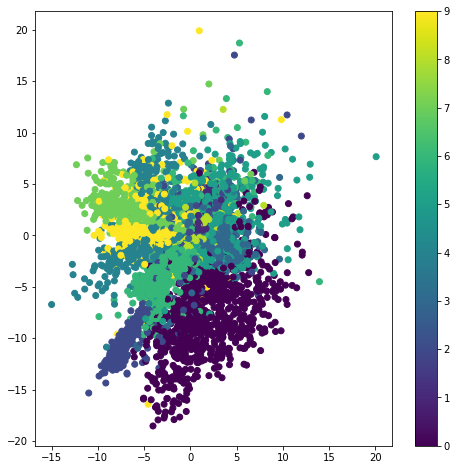

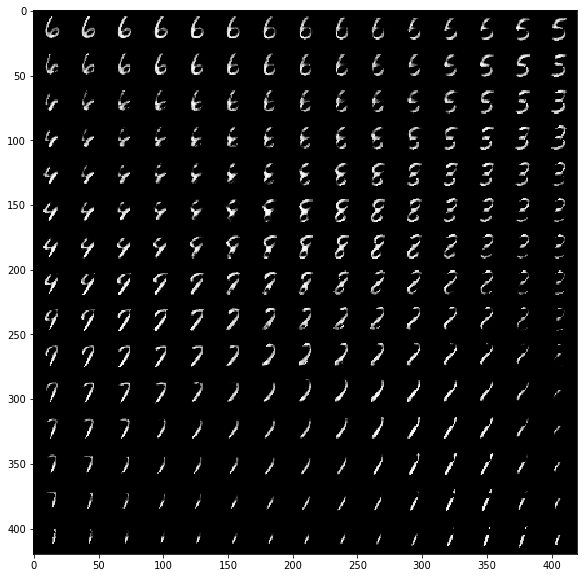

In [16]:
import numpy as np
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
from scipy.stats import norm
from keras import backend as K

#import and load MNIST database
from keras.datasets import mnist
#leave out labels as that are not necessary
(X_train, _), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test.reshape(10000, 784)

#for reproducible results
seed = 1
np.random.seed(seed)

#hyperparameters
epochs = 200
batch_size = 100
starting_dim = 784
hidden_dim = 256
latent_dim = 2

#encoder
e = Input(batch_shape=(batch_size, starting_dim))
hidden_layer = Dense(hidden_dim, activation='relu')(e)
latent_mean = Dense(latent_dim)(hidden_layer)
latent_log_sigma = Dense(latent_dim)(hidden_layer)

#sampling function
def sampling(args):
    z_mean, z_log_sigma = args
    x = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1.0)
    #reparameterization trick: z=μ+σ⊙x
    return z_mean + K.exp(z_log_sigma) * x

#wrap z as a layer
z = Lambda(sampling)([latent_mean, latent_log_sigma])

#decoder
decoder_hidden_layer = Dense(hidden_dim, activation='relu')
decoder_mean = Dense(starting_dim, activation='sigmoid')
decoded_hidden = decoder_hidden_layer(z)
decoder_output = decoder_mean(decoded_hidden)

#construct VAE, encoder, and generator as functional models
VAE = Model(e, decoder_output)

encoder = Model(e, latent_mean)

gen_start = Input(shape=(latent_dim,))
gen_hidden_layer = decoder_hidden_layer(gen_start)
gen_output = decoder_mean(gen_hidden_layer)
generator = Model(gen_start, gen_output)

def vae_loss(before, after):
    construction_loss = K.sum(K.binary_crossentropy(before, after), axis=1)
    kl_loss = - 0.5 * K.mean(1 + latent_log_sigma - K.square(latent_mean) - K.exp(latent_log_sigma), axis=-1)
    return construction_loss + kl_loss

VAE.compile(optimizer='rmsprop', loss=vae_loss)

VAE.fit(X_train, X_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1)

#plot latent space
points = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c=y_test)
plt.colorbar()
plt.show()

#plot example generated images from decoder
dimensions = 15
image_dimension_size = 28
figure = np.zeros((image_dimension_size * dimensions, image_dimension_size * dimensions))

x_axis = norm.ppf(np.linspace(0.05, 0.95, n)) 
y_axis = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        latent_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(latent_sample)
        gen_num = x_decoded[0].reshape(image_dimension_size, image_dimension_size)
        figure[i * image_dimension_size: (i + 1) * image_dimension_size,
               j * image_dimension_size: (j + 1) * image_dimension_size]=gen_num

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()